# Credit Risk Early Warning System

This notebook builds an early warning system to monitor risk in an equity portfolio, using NIFTY 50 stocks as the case study.

The idea is to track signs of stress in the market using simple, intuitive indicators such as sudden increases in volatility, changes in market sensitivity (beta), large drawdowns from recent peaks, and short-term return outliers. Along with these rule-based signals, an unsupervised machine learning model is used to flag unusual behaviour that does not fit normal historical patterns.

When several of these signals point to elevated risk at the same time, the system automatically sends an email alert, making it useful as a practical monitoring tool rather than just an analysis notebook.


## 1. Overview & Setup

Here we set up the environment by importing the required libraries and defining the core parameters used throughout the notebook.

The system monitors five different risk signals: short-term volatility spikes using rolling statistics, changes in stock beta relative to the NIFTY 50 index (^NSEI), large drawdowns beyond 15%, short-term return outliers measured using rolling Z-scores, and anomalies detected using an Isolation Forest model.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Core parameters -
TICKERS = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS']  # Sample NIFTY stocks
MARKET = '^NSEI'  # NIFTY 50 index
PERIOD = '2y'     # Data period
WINDOW = 252      # Rolling window (1 trading year)
VOL_THRESH = 2.0  # Volatility spike Z-score
BETA_THRESH = 0.2 # Beta drift threshold
DD_THRESH = 0.15  # Drawdown threshold
Z_THRESH = 2.5    # Z-score outlier
CONTAM = 0.1      # Expected ML anomalies

## 2. Data Acquisition

Historical price data for the selected stocks and the NIFTY 50 index are downloaded using the `yfinance` library. Adjusted closing prices are used to account for corporate actions, and log returns are computed for all subsequent risk calculations.


In [3]:
# Download adjusted close prices
prices = yf.download(
    TICKERS + [MARKET], period=PERIOD, auto_adjust=True)['Close']

# Log returns
returns = np.log(prices).diff().dropna()

print("Price data shape:", prices.shape)
print("Returns shape:", returns.shape)
print("\nReturns head:\n", returns.head())


[*********************100%***********************]  6 of 6 completed

Price data shape: (498, 6)
Returns shape: (493, 6)

Returns head:
 Ticker      HDFCBANK.NS  HINDUNILVR.NS   INFY.NS  RELIANCE.NS    TCS.NS  \
Date                                                                      
2024-01-10     0.003297      -0.000911 -0.006166     0.026614  0.006254   
2024-01-11    -0.004206      -0.016114 -0.017054     0.025961  0.006041   
2024-01-12    -0.004741       0.003071  0.076350     0.007929  0.038662   
2024-01-15     0.019071       0.011413  0.024106     0.016927  0.005394   
2024-01-16     0.003789      -0.001595 -0.012517    -0.014086 -0.010947   

Ticker         ^NSEI  
Date                  
2024-01-10  0.003422  
2024-01-11  0.001317  
2024-01-12  0.011362  
2024-01-15  0.009224  
2024-01-16 -0.002953  


## 3. Volatility Monitoring

Short-term market stress is tracked using a 21-day rolling standard deviation of log returns, annualised for consistency. Current volatility is compared to its own 6-month history, and unusually large deviations are flagged as volatility spikes. This helps capture sudden increases in uncertainty that often precede broader risk events.



Volatility spike signals (1 = spike):
            RELIANCE.NS  TCS.NS  HDFCBANK.NS  INFY.NS  HINDUNILVR.NS
Date                                                                
2026-01-05            0       0            0        0              0
2026-01-06            0       0            0        0              0
2026-01-07            0       0            0        0              0
2026-01-08            0       0            0        0              0
2026-01-09            0       0            0        0              0


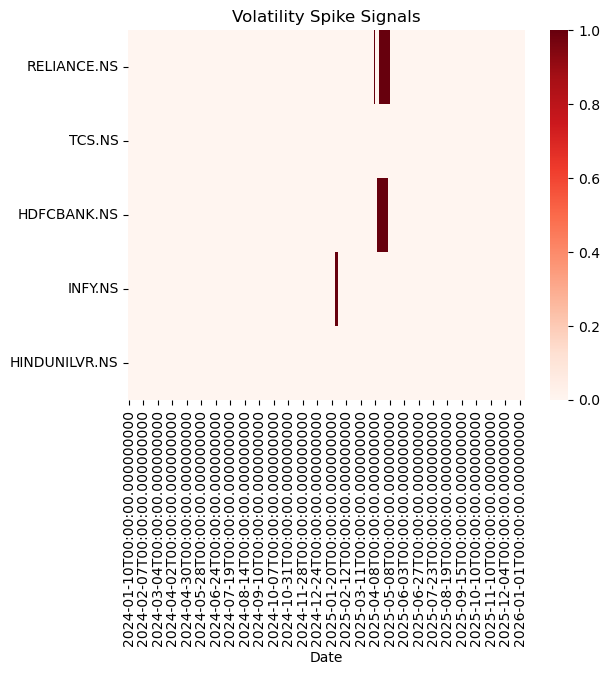

In [4]:
vol_signals = pd.DataFrame(index=returns.index)
vol_zscores = pd.DataFrame(index=returns.index)

for ticker in TICKERS:
    ret = returns[ticker].dropna()

    # 21-day rolling volatility (annualised)
    roll_vol = ret.rolling(21).std() * np.sqrt(252)

   
    vol_mean = roll_vol.rolling(126).mean()
    vol_std = roll_vol.rolling(126).std()

    vol_z = (roll_vol - vol_mean) / vol_std

    vol_zscores[ticker] = vol_z
    vol_signals[ticker] = (vol_z > VOL_THRESH).astype(int)

print("\nVolatility spike signals (1 = spike):")
print(vol_signals.tail())

sns.heatmap(vol_signals.T, cmap="Reds", cbar=True)
plt.title("Volatility Spike Signals")
plt.show()

## 4. Beta Drift Monitoring

To monitor changes in market sensitivity, a 252-day rolling beta is estimated for each stock relative to the NIFTY 50 index (^NSEI). Instead of using fixed beta levels, the focus is on beta stability. Large deviations from a stock’s historical beta behaviour are flagged as potential warning signs of changing risk exposure.


Recent Beta Drift Signals (1 = drift):
            RELIANCE.NS  TCS.NS  HDFCBANK.NS  INFY.NS  HINDUNILVR.NS
Date                                                                
2026-01-05            0       0            0        0              0
2026-01-06            0       0            0        0              0
2026-01-07            0       0            0        0              0
2026-01-08            0       0            0        0              0
2026-01-09            0       0            0        0              0


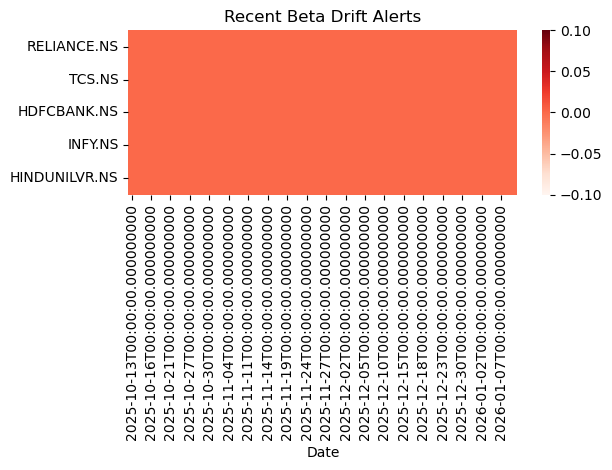

In [5]:
beta_signals = pd.DataFrame(index=returns.index)
beta_values = pd.DataFrame(index=returns.index)

for ticker in TICKERS:
    stock_ret = returns[ticker]
    mkt_ret = returns[MARKET]

    # Rolling beta (252 trading days)
    cov = stock_ret.rolling(252).cov(mkt_ret)
    var = mkt_ret.rolling(252).var()
    beta = cov / var

    beta_values[ticker] = beta

    # Flag beta drift using Z-score
    beta_mean = beta.rolling(252).mean()
    beta_std = beta.rolling(252).std()
    beta_z = (beta - beta_mean) / beta_std

    beta_signals[ticker] = (beta_z.abs() > 2).astype(int)

print("Recent Beta Drift Signals (1 = drift):")
print(beta_signals.tail())

sns.heatmap(
    beta_signals.tail(60).T,
    cmap="Reds",
    cbar=True,
    yticklabels=TICKERS
)
plt.title("Recent Beta Drift Alerts")
plt.tight_layout()
plt.show()

## 5. Drawdown Monitoring

Drawdowns are computed as the percentage decline from the most recent peak price for each stock. A risk signal is triggered when the drawdown exceeds 15%, highlighting sustained losses that may indicate deeper structural stress rather than temporary price movements.


In [6]:
dd_signals = pd.DataFrame(index=returns.index)
drawdowns = pd.DataFrame(index=returns.index)

for ticker in TICKERS:
    price = prices[ticker].dropna()

    # Drawdown from historical peak
    peak = price.cummax()
    drawdown = (price - peak) / peak

    drawdowns[ticker] = drawdown
    dd_signals[ticker] = (drawdown < -DD_THRESH).astype(int)

print("Recent Drawdown Signals (1 = breach):")
print(dd_signals.tail())

Recent Drawdown Signals (1 = breach):
            RELIANCE.NS  TCS.NS  HDFCBANK.NS  INFY.NS  HINDUNILVR.NS
Date                                                                
2026-01-05            0       1            0        1              1
2026-01-06            0       1            0        1              1
2026-01-07            0       1            0        1              1
2026-01-08            0       1            0        1              1
2026-01-09            0       1            0        1              1


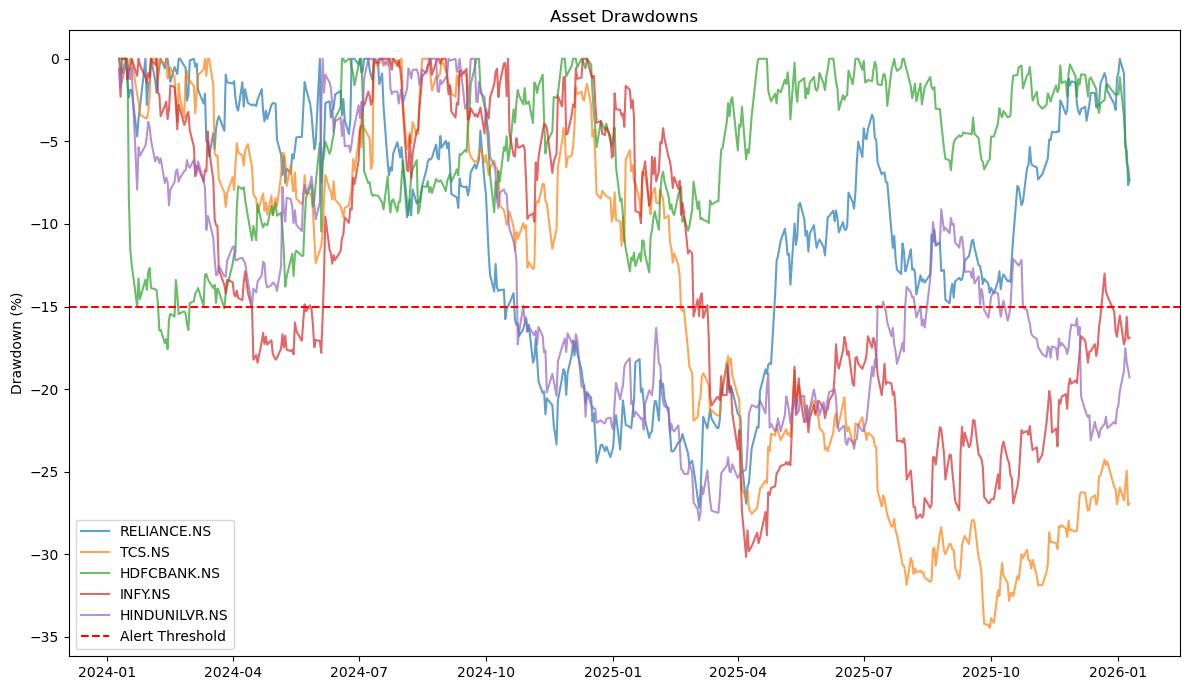

In [7]:
# Drawdown visualization
plt.figure(figsize=(12, 7))

for ticker in TICKERS:
    plt.plot(drawdowns[ticker].index, drawdowns[ticker] * 100, label=ticker, alpha=0.7)

plt.axhline(-DD_THRESH * 100, color="red", linestyle="--", label="Alert Threshold")
plt.title("Asset Drawdowns")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.tight_layout()
plt.show()

## 6. Rolling Z-Score Monitoring

Short-term return shocks are identified using 30-day rolling Z-scores of log returns. Extreme moves, defined as Z-scores beyond ±2.5, are flagged as outliers. This signal is treated as a confirmation indicator, helping detect abrupt market reactions or news-driven events.


In [8]:
z_signals = pd.DataFrame(index=returns.index)
z_scores = pd.DataFrame(index=returns.index)

for ticker in TICKERS:
    ret = returns[ticker]

    roll_mean = ret.rolling(30).mean()
    roll_std = ret.rolling(30).std()

    z = (ret - roll_mean) / roll_std

    z_scores[ticker] = z
    z_signals[ticker] = (z.abs() > Z_THRESH).astype(int)

print("Recent Z-score Signals (1 = extreme move):")
print(z_signals.tail())


Recent Z-score Signals (1 = extreme move):
            RELIANCE.NS  TCS.NS  HDFCBANK.NS  INFY.NS  HINDUNILVR.NS
Date                                                                
2026-01-05            0       0            1        0              0
2026-01-06            1       0            0        0              0
2026-01-07            0       0            0        0              0
2026-01-08            0       1            0        0              0
2026-01-09            0       0            0        0              0


<Figure size 1200x800 with 0 Axes>

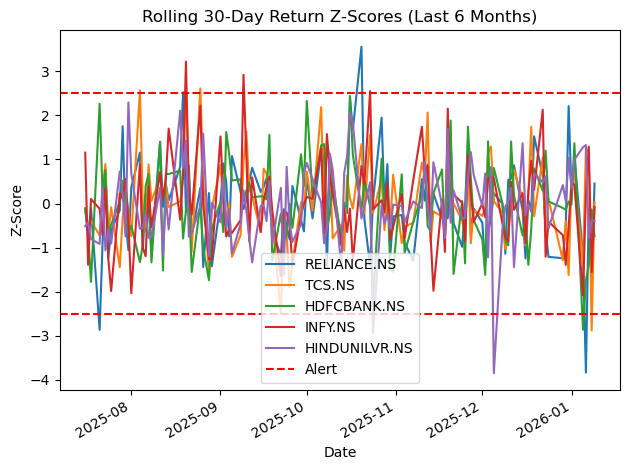

In [9]:
# Z-score visualization
plt.figure(figsize=(12, 8))
z_scores.tail(120).plot()

plt.axhline(Z_THRESH, color="red", linestyle="--", label="Alert")
plt.axhline(-Z_THRESH, color="red", linestyle="--")

plt.title("Rolling 30-Day Return Z-Scores (Last 6 Months)")
plt.ylabel("Z-Score")
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

## 7. ML-Based Anomaly Detection

An unsupervised Isolation Forest model is used to detect abnormal behaviour by jointly analysing multiple continuous risk features, including volatility, beta, drawdown, and return Z-scores. The model is trained on recent historical data and flags observations that deviate significantly from normal patterns, providing a data-driven early warning layer.


Recent ML anomaly signals (1 = anomaly):
            RELIANCE.NS  TCS.NS  HDFCBANK.NS  INFY.NS  HINDUNILVR.NS
Date                                                                
2026-01-05          0.0     0.0          1.0      1.0            0.0
2026-01-06          1.0     0.0          0.0      0.0            1.0
2026-01-07          0.0     0.0          0.0      0.0            0.0
2026-01-08          0.0     1.0          0.0      0.0            0.0
2026-01-09          0.0     0.0          1.0      0.0            0.0


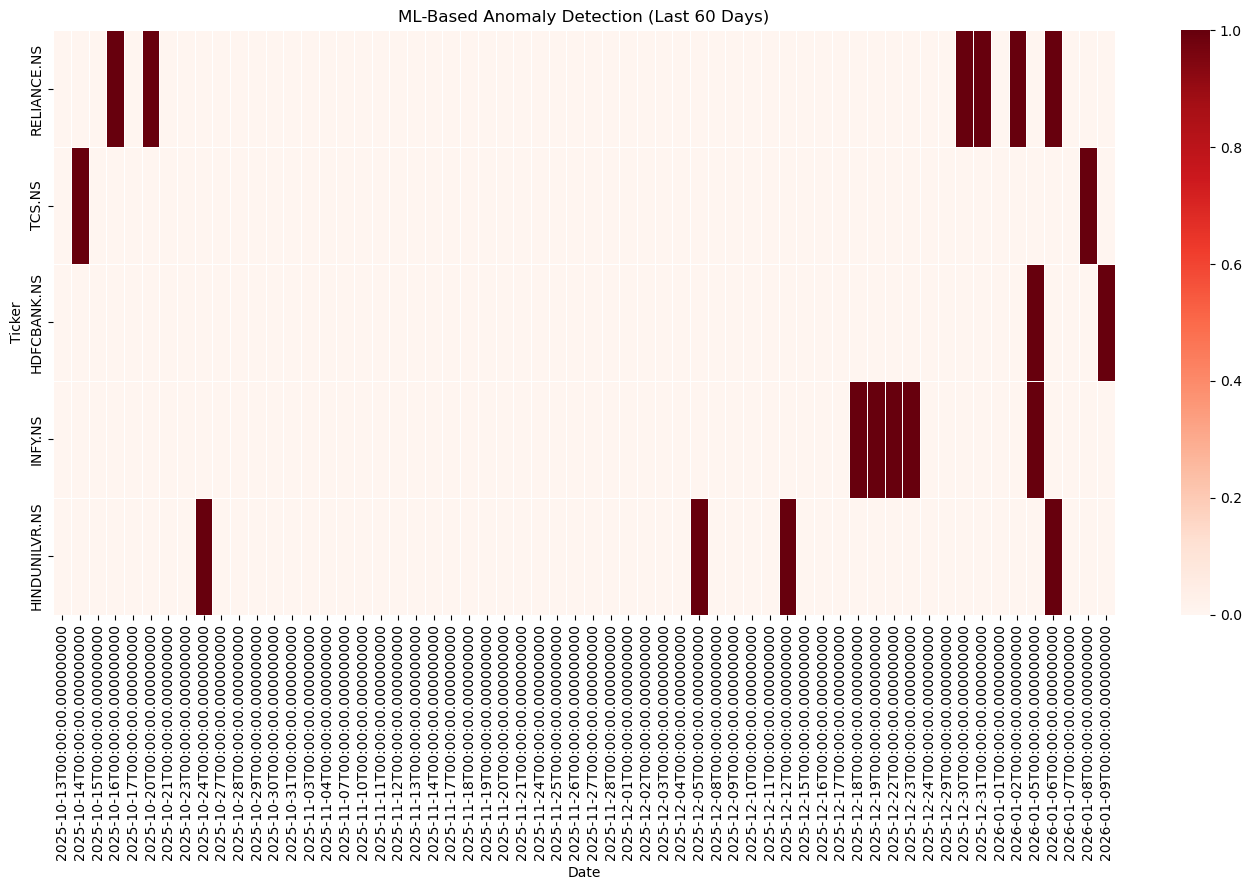

In [10]:
ml_signals = pd.DataFrame(index=returns.index)

for ticker in TICKERS:
    X = pd.DataFrame(index=returns.index)

    # Volatility (continuous)
    X["vol"] = vol_zscores[ticker]

    # Beta (continuous)
    X["beta"] = beta_values[ticker]

    # Drawdown (continuous)
    X["drawdown"] = drawdowns[ticker]

    # Return Z-score (continuous)
    X["ret_z"] = z_scores[ticker]

    X = X.dropna()

    # Scale Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Training Isolation Forest
    iso = IsolationForest(contamination=CONTAM, random_state=42)
    preds = iso.fit_predict(X_scaled)

    ml_signals.loc[X.index, ticker] = (preds == -1).astype(int)

print("Recent ML anomaly signals (1 = anomaly):")
print(ml_signals.tail())

plt.figure(figsize=(14, 4 + len(TICKERS)))

sns.heatmap(ml_signals.tail(60).T, cmap="Reds", cbar=True, linewidths=0.5)

plt.title("ML-Based Anomaly Detection (Last 60 Days)")
plt.xlabel("Date")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()

## 8. Alert System

Individual risk signals are combined into a composite alert framework. An email alert is triggered when three or more independent signals activate simultaneously, or when a machine learning anomaly is detected on its own. This aggregation step helps reduce false positives and ensures alerts are raised only during meaningful risk events.


In [12]:
import os
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

In [13]:
# Load Credentials
EMAIL = os.getenv("ALERT_EMAIL")
APP_PASSWORD = os.getenv("EMAIL_APP_PASSWORD")

if EMAIL is None or APP_PASSWORD is None:
    raise ValueError("Email credentials not found in environment variables")


In [14]:
def send_email_alert(subject, body):
    msg = MIMEMultipart()
    msg["From"] = EMAIL
    msg["To"] = EMAIL
    msg["Subject"] = subject

    msg.attach(MIMEText(body, "plain"))

    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
        server.login(EMAIL, APP_PASSWORD)
        server.send_message(msg)


In [19]:
def generate_alert_signal(date, ticker):
    signals = {
        "Volatility Spike": vol_signals.loc[date, ticker],
        "Beta Drift": beta_signals.loc[date, ticker],
        "Drawdown Breach": dd_signals.loc[date, ticker],
        "Z Score": z_signals.loc[date, ticker],
        "ML Anomaly": ml_signals.loc[date, ticker]
    }

    fired = [k for k, v in signals.items() if v == 1]

    alert = (len(fired) >= 3) or ("ML Anomaly" in fired)
    return alert, fired


In [20]:
for date in returns.index[-5:]:     # recent days
    for ticker in TICKERS:
        alert, fired = generate_alert_signal(date, ticker)

        if alert:
            subject = f"Credit Risk Alert: {ticker}"
            body = f"""
Date: {date}

Triggered Signals:
{', '.join(fired)}
"""

            send_email_alert(subject, body)


## 9. Conclusion

This project demonstrates how a simple yet structured early warning system can be built by combining intuitive market-based risk indicators with a lightweight machine learning model. By focusing on interpretability, signal confirmation, and secure alerting, the system is designed to be practical and easy to extend rather than overly complex.

While the current setup is applied to NIFTY 50 equities, the same framework can be adapted to other asset classes, markets, or risk thresholds, making it a flexible foundation for further risk monitoring and analysis.
